# Cubic splines

The file `cubic_splines.pdf` presents some notes about the cubic splines method.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

#used for inserting images
from IPython.display import Image as img

In [12]:
L = 5
x = np.linspace(0., 10., L) # x coordinates of the data
y = np.sin(2.*np.pi*x/10.)  # data values

In [3]:
x0 = np.linspace(0., 10., 5+3*4) # x coordinates of the interpolating points
y0 = np.sin(2.*np.pi*x0/10.)   # true values of the original function at the interpolation points

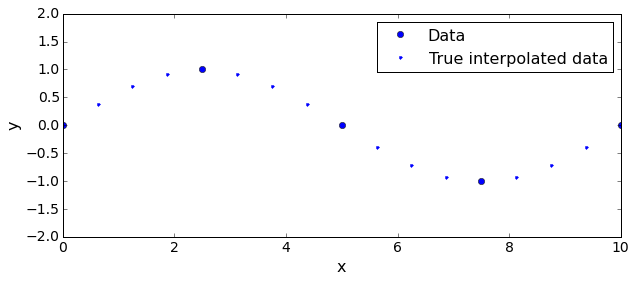

In [4]:
plt.figure(figsize=(10,10))
plt.axis('scaled')
plt.plot(x, y, 'bo', label='Data')
plt.plot(x0, y0, 'b.', label='True interpolated data')
plt.xlim(np.min(x0), np.max(x0))
plt.ylim(-2., 2.)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', numpoints=1, fontsize=16)
plt.show()

In [5]:
def spline3(x, f):
    
    L = y.size
    
    g = 3.*np.hstack(((f[1] - f[0]), (f[2:] - f[:L-2]), (f[-1] - f[-2])))

    indices = np.arange(L)
    A = np.zeros((L,L))
    A[indices[1:L-1],indices[1:L-1]] = 4
    A[0,0] = 2
    A[L-1,L-1] = 2
    A[indices[:L-1],indices[1:]] = 1
    A[indices[1:],indices[:L-1]] = 1
    
    D = np.linalg.solve(A, g)
    
    c = 3.*(f[1:] - f[:L-1]) - 2.*D[:L-1] - D[1:]
    d = 2.*(f[:L-1] - f[1:]) + D[:L-1] + D[1:]
    
    return D, c, d

In [6]:
def spline3_interpolate(a,b,c,d,t):
    
    result = np.outer(a,np.ones_like(t))
    t *= t 
    result += np.outer(b,t)
    t *= t
    result += np.outer(c,t)
    t *= t
    result += np.outer(d,t)
    
    return result

In [7]:
b,c,d = spline3(x,y)

In [13]:
t = np.linspace(0.33333, 0.66666, 3)
y0_calc = spline3_interpolate(y[:L-1],b[:L-1],c,d,t)

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('scaled')
plt.plot(x, y, 'bo', label='Data')
plt.plot(x0, y0, 'b.', label='True interpolated data')
plt.plot(x0, y0_calc, 'b.', label='Interpolated data')
plt.xlim(np.min(x0), np.max(x0))
plt.ylim(-2., 2.)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', numpoints=1, fontsize=16)
plt.show()

### Exercise 25

The folder `synthetic_gravity_data` contains a jupyter notebook named [`synthetic_data_fatiando.ipynb`](https://nbviewer.jupyter.org/github/birocoles/Disciplina-metodos-computacionais/blob/master/Content/synthetic_gravity_data/synthetic_data_fatiando.ipynb). This code uses the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://www.fatiando.org/) for calculating the gravity anomaly produced by the following synthetic body:

In [ ]:
img('synthetic_gravity_data/model.png')

The synthetic body shown above produces the gravity anomaly shown below:

In [ ]:
img('synthetic_gravity_data/map.png')

In [ ]:
img('synthetic_gravity_data/profile.png')

The files `synthetic_gravity_data/gravity_anomaly.txt` and `synthetic_gravity_data/gravity_anomaly_profile.txt` contain, respectively, the synthetic gravity anomaly map and the gravity anomaly profile on x = 0 m.

To solve this exercise:

1. Load the file `synthetic_gravity_data/gravity_anomaly_profile.txt` by using the routine [`numpy.loadtxt`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html). 

2. Use the function `my_neville` to calculate one interpolated gravity data between two adjacent gravity data (black dots on the gravity profile) on the profile.

3. Plot a Figure similar to the gravity profile shown above containing: (i) the original data (black dots on the gravity profile) and (ii) the interpolated points.